# Variational AutoEncode using pytorch on MNIST

This notebook is to illustrate the conept of Variational Auto-Encoder on MNIST data. VAE is a unsupervised (or semi-supervised) technique.

The basic principle is that using an Encoding NN the input data features are reduced into a latent space, and then with another Decoder netword the opposite happens and the decoding network learns to create the original image from the latent space.

The applications could be creating similar outputs to the original dataset that have not been created before. Thus it can have applications in generative or data augmentation application.

Also a very powerful application could be in de-noising. Noise can be treated as higher frequency data that will be filter as we go to the latent space. This can be a powerful technique in image processing.

However, this notebook is only showing how the VAE can result in simple classification. Similar to the previous notebook on MNIST numbers for dimension reduction, a VAE is created to reduce the dimension to 2 for the 28x28 images!

## Importing the libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

from torchvision.utils import save_image, make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [2]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
print(f"Available device is {DEVICE}")


Available device is cuda


## Read the data

Instead of reading the data from the csv file, that could be painful to transform into suitable format for dataloader, it is read from torch datasets.

Torch has a dataloader that can take care of batch creation, it works and we don't need to make a data-generator. We read the data and send it to the dataloader that will be called during training and validation.

Data visualization is skipped as it was done in the other notebook on this dataset.

In [3]:
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([transforms.ToTensor()])

batch_size = 100
train_dataset = torchvision.datasets.MNIST('~/datasets', transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('~/datasets', transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)#, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)#, **kwargs)

In [4]:
x_dim  = 784

# Creating the encode and decoder

First encoder is created. 

nn.Module is base class for all torch nn model and our models should extend (inherit from) this class. [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

The encode model has 4 dense (linear layers):
- First layer has dimensions of x_dim x h_dim
- Second layer has dimensions of h_dim x h_dim
- Third layer has dimensions of h_dum x l_dim

The model has two vector output with dimension of the latent space (l_dim). One is to learn a mean and the other one is to learn the variance.

In [5]:
h_dim = 400
l_dim = 2

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, x_dim, h_dim, l_dim):
        super(Encoder, self).__init__()

        self.FC_l1 = nn.Linear(x_dim, h_dim)
        self.FC_l2 = nn.Linear(h_dim, h_dim)
        self.FC_latent_mean  = nn.Linear(h_dim, l_dim)
        self.FC_latent_var   = nn.Linear (h_dim, l_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_l1(x))
        h_       = self.LeakyReLU(self.FC_l2(h_))
        mean     = self.FC_latent_mean(h_)
        log_var  = self.FC_latent_var(h_)                 
                                                       
        
        return mean, log_var

The decoder simply does the opposite of the encode and has layers to transform the latent space back into the input data space. So it does not care about variations. 

It returns the sigmoid of the output layer with dimensions of input and it will be used when calculating the loss.

In [7]:
class Decoder(nn.Module):
    def __init__(self, l_dim, h_dim, x_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(l_dim, h_dim)
        self.FC_hidden2 = nn.Linear(h_dim, h_dim)
        self.FC_output = nn.Linear(h_dim, x_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

## Creating the model

To create the model the encode and decoder are passed to the final model.

The model takes the input, passes that through the encoder> The encoder returns the learnt latent space and the learnt log of the variance in the latent space (We will see how later). So the encoder output are two vectors of:
$$
 [\mu_{1}, \mu_{2},... , \mu_{n}]
$$
and
$$
 [log(\sigma^2_{1}), log(\sigma^2_{2}),... , log(\sigma^2_{n})]
$$

where $\sigma_{i}$ is the variance of the ith dimension of the latent space from the training dataset that we will give to it.

The model will modify the latent space to $\mu_{i} + \epsilon \sigma_{i}$ for all i in the latent space. Where $\epsilon$ is a guassian random number between 0 and 1. The ideas to create a random latent space based on the input but the randomness is guassian and in the variance is the same as the learn variance.

So the decoder creates a latent space vector as below from the inputs of the encoder. 

$$
 [\mu_{1} + \epsilon_{1}\sigma_{1}, \mu_{2} + \epsilon_{1}\sigma_{1},... , \mu_{n} + + \epsilon_{n}\sigma_{n}]
$$

And then it sends it to the decoder to create the output in the input data space.

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [9]:
encoder = Encoder(x_dim, h_dim, l_dim)
decoder = Decoder(l_dim, h_dim, x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

## Defining the loss function

The goal of the decoder is to calculate the probability distribution of

The encoder calculates the probability of the latent space given an input x

$$
P(z|x) = \frac{P(x|z)P(z)}{P(x)}\
$$

Calculating this is not possible because $P(x)$ is not known and can only be presented as $\Sigma_{z}P(x|z)P(z)$
The idea is to find another known distribution, Q(z), as close as possible by minimize the KL divergence between P(z|x) and Q(z).

$$
min KL(P(z|x) || Q(z)) = -\Sigma_{z}Q(z)log(\frac{P(z|x)}{Q(z)})
$$

Using the first equation:

$$
min KL(P(z|x) || Q(z)) = -\Sigma_{z}Q(z)log(\frac{\frac{P(x,z)}{P(x)}}{Q(z)}) = -\Sigma_{z}Q(z)log(\frac{P(x,z)}{Q(z)}) + \Sigma_{z}Q(z)logP(x) = -\Sigma_{z}Q(z)log(\frac{P(x,z)}{Q(z)}) + logP(x)
$$

The term $\Lambda = \Sigma_{z}Q(z)log(\frac{P(x,z)}{Q(z)})$ is called variational lower bound. Instead the optimization process could aim to maximize this term. It is lower bound because since KL is always positive $\Lambda <= logP(x)$

Writing the equations now for $\Lambda $:

$$
\Lambda = \Sigma_{z}Q(z)log(\frac{P(x,z)}{Q(z)}) = \Sigma_{z}Q(z)log(\frac{P(x|z)P(z)}{Q(z)}) = \Sigma_{z}Q(z)logP(x|z) + \Sigma_{z}Q(z)log(\frac{P(z)}{Q(z)})
$$

Or:

$$
\Lambda = \Sigma_{z}Q(z)logP(x|z) - KL(Q(z)|| P(z)) = \Sigma_{z}Q(z)logP(x|\hat{x}) - KL(Q(z)|| P(z))
$$

Encoder gives Q(z|x) for input x, and the decoder output P(x|z) given a laten space z. Since the decoder part is deterministic we can also write it as $P(x|\hat{x})$

For the loss function as above we calculate the first part $\Sigma_{z}Q(z)logP(x|\hat{x})$ as the cross-entropy between the input and output layer. This is called the reproduction cost.

The KL term is KL between two guasian distribution. One is Q(z) which is N(0, 1) (for all the dimensions in the latent space) and for the other one mean and variance are given as the outputs of the encoder. The KL between two guassians as calculate exactly in [Link](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

Since we have chosen the encoder to output the logVariance instead of variance or standard deviation the calculations will also be based on that.

$$
KL (p(\mu_1, \sigma_1) | q(\mu_2, \sigma_2)) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma^2_1 + (\mu_1 - \mu_2)^2}{2\sigma^2_2} - \frac{1}{2}
$$

$$
\mu1 = mean
$$
$$
\sigma1 = exp(0.5 * logvar) 
$$
$$
\mu2 = 0
$$
$$
\sigma2 = 1
$$

Therefore,
$$
KL (p(\mu_1, \sigma_1) | q(\mu_2, \sigma_2)) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma^2_1 + (\mu_1 - \mu_2)^2}{2\sigma^2_2} - \frac{1}{2}
$$

$$
KL (p(\mu_1, \sigma_1) | q(\mu_2, \sigma_2)) = log\frac{1}{exp(0.5 * logvar)} + \frac{(exp(0.5 * logvar))^2  + (mean)^2}{2} - \frac{1}{2}
$$

$$
KL (p(\mu_1, \sigma_1) | q(\mu_2, \sigma_2)) = -0.5 * logvar + \frac{exp(logvar)  + (mean)^2}{2} - \frac{1}{2}
$$

can be summerized as:

$$
KL (p(\mu_1, \sigma_1) | q(\mu_2, \sigma_2)) = \frac{-logvar + exp(logvar)  + (mean)^2 - 1}{2}
$$

And this has to be summed on all the dimensions of the latent space.

In [10]:
from torch.optim import Adam
lr = 1e-3

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL      = torch.sum(-log_var + log_var.exp() + mean.pow(2) - 1) / 2
    
    return reproduction_loss + KL

optimizer = Adam(model.parameters(), lr=lr)

# Training the model

In [11]:
epochs = 10

In [12]:
print("Training the Variational AutoEncoder")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm((train_loader))):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tLoss: ", overall_loss / (batch_idx * batch_size))
    
print("Finish!!")

Training the Variational AutoEncoder


100%|██████████| 600/600 [00:08<00:00, 68.66it/s]


	Epoch 1 complete! 	Loss:  179.93606578998853


100%|██████████| 600/600 [00:07<00:00, 80.98it/s]


	Epoch 2 complete! 	Loss:  163.77899942286624


100%|██████████| 600/600 [00:07<00:00, 80.24it/s]


	Epoch 3 complete! 	Loss:  159.37649590137207


100%|██████████| 600/600 [00:07<00:00, 80.96it/s]


	Epoch 4 complete! 	Loss:  156.94567123591403


100%|██████████| 600/600 [00:07<00:00, 81.23it/s]


	Epoch 5 complete! 	Loss:  155.19130173009702


100%|██████████| 600/600 [00:07<00:00, 81.36it/s]


	Epoch 6 complete! 	Loss:  153.79506899520032


100%|██████████| 600/600 [00:07<00:00, 80.20it/s]


	Epoch 7 complete! 	Loss:  152.72341056709098


100%|██████████| 600/600 [00:07<00:00, 80.98it/s]


	Epoch 8 complete! 	Loss:  151.90203071199394


100%|██████████| 600/600 [00:07<00:00, 81.03it/s]


	Epoch 9 complete! 	Loss:  151.15632463611226


100%|██████████| 600/600 [00:07<00:00, 81.58it/s]

	Epoch 10 complete! 	Loss:  150.47466519720368
Finish!!


# Visualizing the result

First we send the test set, that was not seen by the model during the training, and plot the latent space that is for now chosen to be 2, in a 2D scatter plot.

In [13]:
import matplotlib.pyplot as plt

In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [15]:
model.eval()
fig = plt.figure(figsize=(10, 10))
x_arr = []
y_arr = []
l_arr = []
with torch.no_grad():
    for (x, l) in tqdm(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _ = encoder(x)
        
        #x_hat = x_hat.cpu().detach().numpy
        #l = l.cpu().detach().numpy
        for i in range(len(x)):
            x_y = x_hat[i].cpu().detach().numpy()
            x_arr.append(x_y[0])
            y_arr.append(x_y[1])
            
            label = l[i].detach().numpy()
            l_arr.append(label)
            
        

100%|██████████| 100/100 [00:01<00:00, 59.90it/s]


<Figure size 720x720 with 0 Axes>

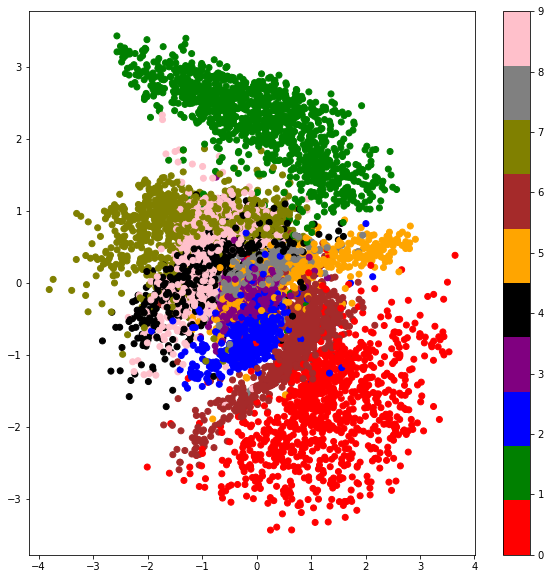

In [16]:
import matplotlib
colors = ['red','green','blue','purple', 'black', 'orange', 'brown', 'olive', 'gray', 'pink']
fig = plt.figure(figsize=(10, 10))
plt.scatter(x_arr, y_arr, c=l_arr, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()


Then we sent the training dataset again through the model and store the latent space for plotting.

In [17]:
model.eval()

x_arr = []
y_arr = []
l_arr = []
with torch.no_grad():
    for (x, l) in tqdm(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _ = encoder(x)
        
        for i in range(len(x)):
            x_y = x_hat[i].cpu().detach().numpy()
            x_arr.append(x_y[0])
            y_arr.append(x_y[1])
            
            label = l[i].detach().numpy()
            l_arr.append(label)
            
        

100%|██████████| 600/600 [00:09<00:00, 64.47it/s]


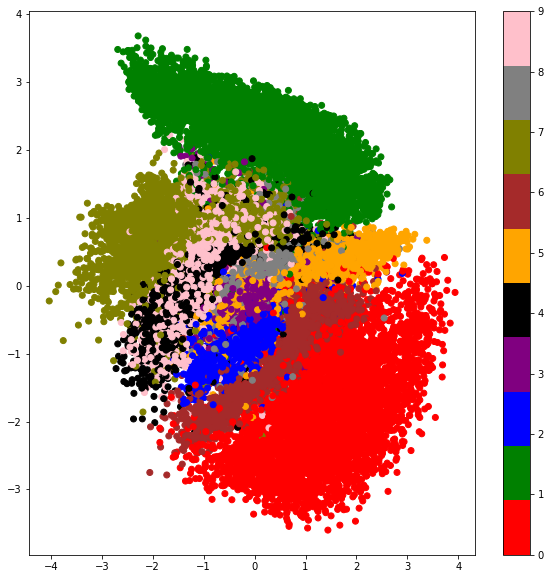

In [18]:
import matplotlib
colors = ['red','green','blue','purple', 'black', 'orange', 'brown', 'olive', 'gray', 'pink']
fig = plt.figure(figsize=(10, 10))
plt.scatter(x_arr, y_arr, c=l_arr, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()


The encoding part can be used for dimension reduction. The performance seem better than PCA. In principle if we did not have the non-linearities the network would converge to what PCA does.

The decoding part can be used for generative tasks. We can take a sample from the latent space, add some noise according the calculated variance, this is called sampling and extract the output of a decoter as a similar but new data. Applications could be in data augmentation, new game character or art generation etc.

Here to illustrate this we sample as the 2D latent space from -4 to +4 in both direction in 0.8 steps and check how the outputs look like.

In [19]:
input_ = []

for i in np.arange(-3, 3, .6):
    for j in np.arange(-3, 3, 0.6):
        input_.append(np.array([i, j]))

input_ = np.array(input_)
input_ = torch.from_numpy(input_).float().to(DEVICE)

In [20]:
with torch.no_grad():
    generated_images = decoder(input_)

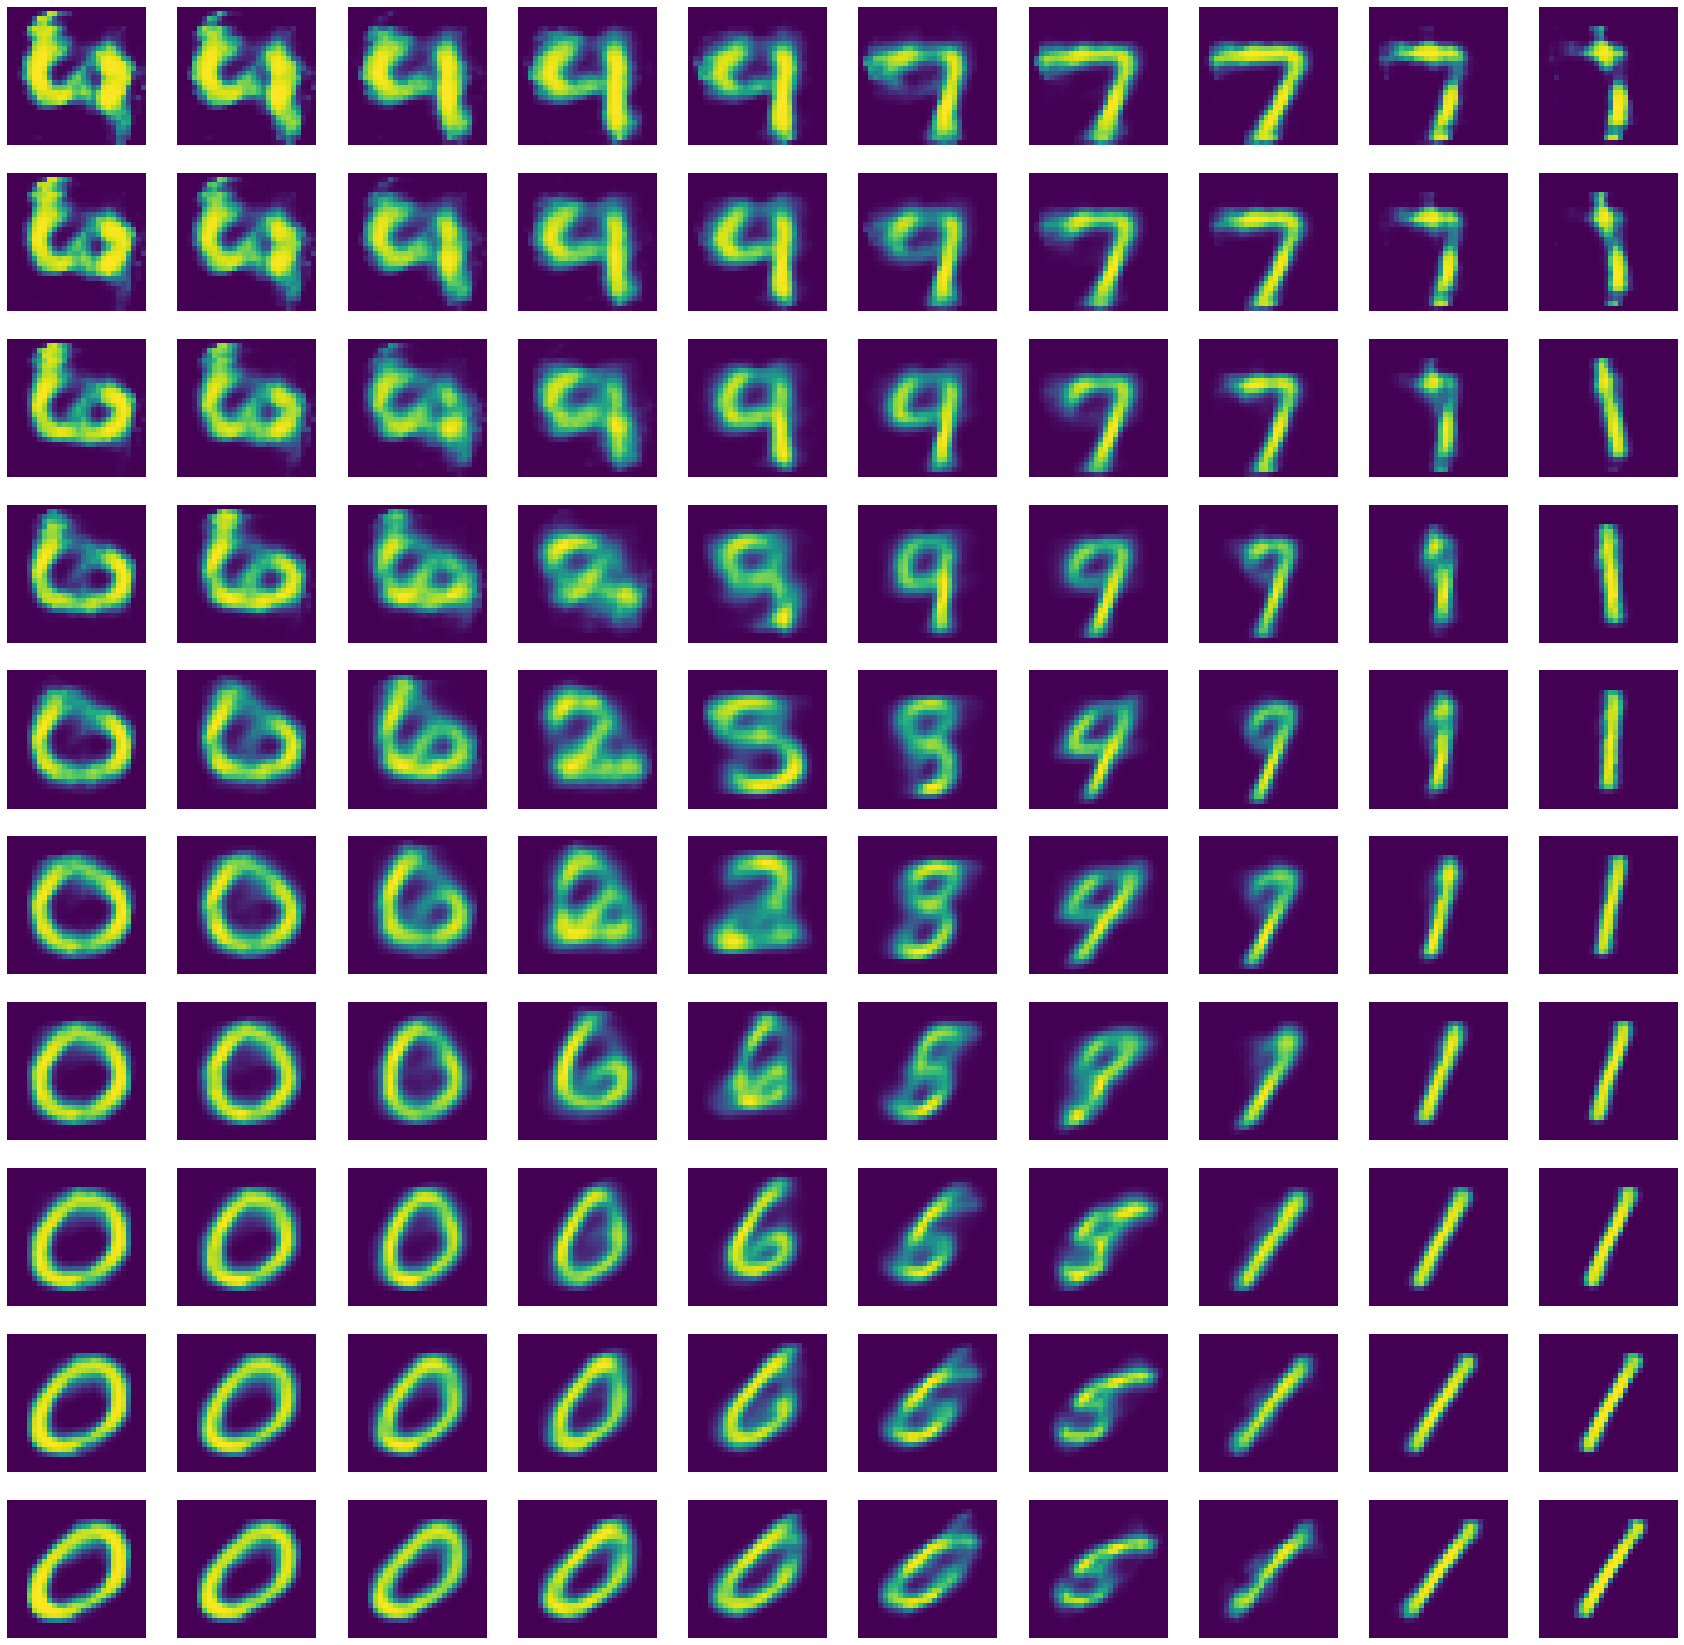

In [21]:
len(generated_images)
fig = plt.figure(figsize=(30, 30))

for i in range(10):
    for j in range(10):
        img = generated_images[j * 10 + i]
        img = img.cpu().detach().numpy()
        img = img.reshape(-1, 28)
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(img)
        plt.axis('off')
